# Philips Supplier Sustainability Analytics - Starter Notebook

This notebook provides a minimal starting point for the assignment.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
import shap

## 2. Load Data

In [2]:
# Load the data
df = pd.read_excel('data/SSP_Data.xlsx')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of unique suppliers: {df['ID'].nunique()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
pd.set_option('display.max_columns', None)
df.head()

Dataset shape: (1262, 495)
Number of unique suppliers: 463
Duplicate rows: 0


,Index,ID,Sequence,Assessment Year,Assessment type,Country,Val_Score,Val_Environment,Val_Health and Safety,Val_Business Ethics,Val_Labor and Human Rights,SAQ_Score,SAQ_Environment,SAQ_Health and Safety,SAQ_Business Ethics,SAQ_Labor and Human Rights,Self Score,Activities - Raw material extraction,Activities - Plastic molding,Activities - Component manufacturing,Activities - Sub-assembly,Activities - Surface treatment / plating,Activities - Printed Circuit Board manufacturing,Activities - Printed Circuit Board assembly / mounting,Activities - Painting / coating,Activities - Silkscreen / pad printing,Activities - Die casting / stamping / metal processing,Activities - Packaging (cardboard / colorbox / pulp tray / label / blister),Activities - Testing and measurement,Activities - Clean room,Activities - Final assembly,Activities - Logistics & distribution,Facilities - Hospital / infirmary,Facilities - Dormitory on site or employer provided accommodation close to the site,Facilities - Canteen,Facilities - Kitchen,Facilities - Power generation,Facilities - Chemical warehouse,Facilities - Waste water treatment facility,Number of workers - Total,Number of workers - Male,Number of workers - Female,Number of workers - Young workers,Number of workers - Direct employed,Number of workers - Indirect employed,Q224,Q291_1,Q291_2,Q291_3,Q291_4,Q291_5,Q291_6,Q291_7,Q291_8,Q291_9,Q291_10,Q225,Q1222,Q1223,Q230,Q293_1,Q293_2,Q293_3,Q293_4,Q293_5,Q293_6,Q293_7,Q293_8,Q293_9,Q293_10,Q1609,Q1610_1,Q1610_2,Q1610_3,Q1610_4,Q1610_5,Q231,Q232,Q1224,Q1225,Q1226,Q1229,Q1230,Q1611,Q1612,Q1231,Q1232,Q1233,Q1463,Q1235,Q1237,Q1613,Q1238,Q258,Q260,Q1239,Q1240,Q263,Q1241,Q301_1,Q301_2,Q301_3,Q301_4,Q301_5,Q301_6,Q301_7,Q301_8,Q301_9,Q301_10,Q277,Q304_1,Q304_2,Q304_3,Q304_4,Q304_5,Q304_6,Q304_7,Q304_8,Q304_9,Q304_10,Q1249,Q1254,Q1255,Q1256_1,Q1256_2,Q1256_3,Q1256_4,Q1256_5,Q1256_6,Q1256_7,Q1256_8,Q1256_9,Q1256_10,Q286,Q1260,Q1261,Q1262,Q1264,Q287_1,Q287_2,Q287_3,Q287_4,Q1265,Q1268,Q1274,Q1272,Q288,Q1275,Q1276,Q552,Q630_1,Q630_2,Q630_3,Q630_4,Q630_5,Q630_6,Q630_7,Q630_8,Q554,Q555,Q556,Q557,Q1614_1,Q1614_2,Q1614_3,Q1614_4,Q1614_5,Q1278,Q1279,Q1280,Q1281,Q1282,Q1283,Q1284,Q1285,Q1287,Q1288,Q1289,Q1290,Q1291,Q1615,Q1616_1,Q1616_2,Q1616_3,Q1616_4,Q1616_5,Q1617,Q561,Q1292,Q1618,Q1293,Q1294,Q1295,Q1296,Q1619,Q1297,Q1299,Q1300,Q1301,Q1302,Q1303,Q1304,Q1620,Q1621,Q592,Q594,Q1305,Q1310,Q597,Q1311,Q636_1,Q636_2,Q636_3,Q636_4,Q636_5,Q636_6,Q636_7,Q615,Q639_1,Q639_2,Q639_3,Q639_4,Q639_5,Q639_6,Q639_7,Q1315,Q1316,Q1319,Q1324,Q620,Q1325_1,Q1325_2,Q1325_3,Q1325_4,Q1325_5,Q1325_6,Q1325_7,Q1325_8,Q624,Q1329,Q1330,Q1331,Q1333,Q625_1,Q625_2,Q625_3,Q625_4,Q1336,Q1339,Q1342,Q1343,Q626,Q1335,Q1334,Q728,Q808_1,Q808_2,Q808_3,Q808_4,Q808_5,Q808_6,Q808_7,Q808_8,Q730,Q731,Q732,Q733,Q809_1,Q809_2,Q809_3,Q809_4,Q809_5,Q809_6,Q809_7,Q809_8,Q736,Q1345,Q1346,Q742,Q748,Q1461,Q756,Q1347,Q1348,Q1349,Q1350,Q1351,Q1352,Q1353,Q1622,Q1623,Q1655,Q1624,Q1625,Q1626,Q769,Q771,Q1354,Q1356,Q774,Q1357,Q817_1,Q817_2,Q817_3,Q817_4,Q817_5,Q817_6,Q817_7,Q817_8,Q792,Q820_1,Q820_2,Q820_3,Q820_4,Q820_5,Q820_6,Q820_7,Q820_8,Q1361,Q1362,Q1365,Q1370,Q798,Q1371_1,Q1371_2,Q1371_3,Q1371_4,Q1371_5,Q1371_6,Q1371_7,Q1371_8,Q802,Q1379,Q1381,Q1382,Q1384,Q1374_1,Q1374_2,Q1374_3,Q1374_4,Q1386,Q1389,Q1391,Q1390,Q804,Q1397,Q1396,Q892,Q958_1,Q958_2,Q958_3,Q958_4,Q958_5,Q958_6,Q958_7,Q958_8,Q958_9,Q958_10,Q958_11,Q958_12,Q958_13,Q893,Q894,Q895,Q896,Q959_1,Q959_2,Q959_3,Q959_4,Q959_5,Q959_6,Q959_7,Q959_8,Q959_9,Q959_10,Q959_11,Q959_12,Q959_13,Q897,Q898,Q967,Q960,Q1629,Q1630,Q1632,Q1633,Q1634,Q1635,Q1636,Q1638,Q1639,Q1640,Q1641,Q1642,Q1643,Q1644,Q1645,Q1646,Q1647,Q1648,Q1649,Q970,Q988_1,Q988_2,Q988_3,Q988_4,Q988_5,Q989,Q1400,Q1403,Q1650,Q1651,Q1652,Q1653,Q1654,Q991,Q1408_1,Q1408_2,Q1408_3,Q1408_4,Q1408_5,Q1406,Q1409_1,Q1409_2,Q1409_3,Q1409_4,Q1409_5,Q1413,Q1412,Q1411,Q924,Q926,Q1416,Q929,Q1417,Q1001_1,Q1001_2,Q1001_3,Q1001_4,Q1001_5,Q1001_6,Q1001_7,Q1001_8,Q1001_9,Q1001_10,Q1001_11,Q943,Q946_1,Q946_2,Q946_3,Q946_4,Q946_5,Q946_6,Q946_7,

In [3]:
#Inspect data types and unique values
print(df.dtypes)
print("\n= Categorical Columns =")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())

Index               object
ID                   int64
Sequence             int64
Assessment Year      int64
Assessment type     object
                    ...   
Q1449              float64
Q1450              float64
Q954               float64
Q956               float64
Q1452              float64
Length: 495, dtype: object

= Categorical Columns =

Index: 1262 unique values
Index
256-1    1
256-2    1
256-3    1
256-4    1
745-1    1
Name: count, dtype: int64

Assessment type: 2 unique values
Assessment type
DV - Desktop Validation    658
SA - Site Assessment       604
Name: count, dtype: int64

Country: 10 unique values
Country
China        1172
India          60
Indonesia      16
Taiwan          6
Thailand        3
Name: count, dtype: int64


## 3. Our Analysis

**Reminder:** Split by supplier ID, not randomly, to avoid data leakage.

In [4]:
df_ohe = pd.get_dummies(df, columns=['Country', 'Assessment type'])

In [5]:
df_ohe

,Index,ID,Sequence,Assessment Year,Val_Score,Val_Environment,Val_Health and Safety,Val_Business Ethics,Val_Labor and Human Rights,SAQ_Score,SAQ_Environment,SAQ_Health and Safety,SAQ_Business Ethics,SAQ_Labor and Human Rights,Self Score,Activities - Raw material extraction,Activities - Plastic molding,Activities - Component manufacturing,Activities - Sub-assembly,Activities - Surface treatment / plating,Activities - Printed Circuit Board manufacturing,Activities - Printed Circuit Board assembly / mounting,Activities - Painting / coating,Activities - Silkscreen / pad printing,Activities - Die casting / stamping / metal processing,Activities - Packaging (cardboard / colorbox / pulp tray / label / blister),Activities - Testing and measurement,Activities - Clean room,Activities - Final assembly,Activities - Logistics & distribution,Facilities - Hospital / infirmary,Facilities - Dormitory on site or employer provided accommodation close to the site,Facilities - Canteen,Facilities - Kitchen,Facilities - Power generation,Facilities - Chemical warehouse,Facilities - Waste water treatment facility,Number of workers - Total,Number of workers - Male,Number of workers - Female,Number of workers - Young workers,Number of workers - Direct employed,Number of workers - Indirect employed,Q224,Q291_1,Q291_2,Q291_3,Q291_4,Q291_5,Q291_6,Q291_7,Q291_8,Q291_9,Q291_10,Q225,Q1222,Q1223,Q230,Q293_1,Q293_2,Q293_3,Q293_4,Q293_5,Q293_6,Q293_7,Q293_8,Q293_9,Q293_10,Q1609,Q1610_1,Q1610_2,Q1610_3,Q1610_4,Q1610_5,Q231,Q232,Q1224,Q1225,Q1226,Q1229,Q1230,Q1611,Q1612,Q1231,Q1232,Q1233,Q1463,Q1235,Q1237,Q1613,Q1238,Q258,Q260,Q1239,Q1240,Q263,Q1241,Q301_1,Q301_2,Q301_3,Q301_4,Q301_5,Q301_6,Q301_7,Q301_8,Q301_9,Q301_10,Q277,Q304_1,Q304_2,Q304_3,Q304_4,Q304_5,Q304_6,Q304_7,Q304_8,Q304_9,Q304_10,Q1249,Q1254,Q1255,Q1256_1,Q1256_2,Q1256_3,Q1256_4,Q1256_5,Q1256_6,Q1256_7,Q1256_8,Q1256_9,Q1256_10,Q286,Q1260,Q1261,Q1262,Q1264,Q287_1,Q287_2,Q287_3,Q287_4,Q1265,Q1268,Q1274,Q1272,Q288,Q1275,Q1276,Q552,Q630_1,Q630_2,Q630_3,Q630_4,Q630_5,Q630_6,Q630_7,Q630_8,Q554,Q555,Q556,Q557,Q1614_1,Q1614_2,Q1614_3,Q1614_4,Q1614_5,Q1278,Q1279,Q1280,Q1281,Q1282,Q1283,Q1284,Q1285,Q1287,Q1288,Q1289,Q1290,Q1291,Q1615,Q1616_1,Q1616_2,Q1616_3,Q1616_4,Q1616_5,Q1617,Q561,Q1292,Q1618,Q1293,Q1294,Q1295,Q1296,Q1619,Q1297,Q1299,Q1300,Q1301,Q1302,Q1303,Q1304,Q1620,Q1621,Q592,Q594,Q1305,Q1310,Q597,Q1311,Q636_1,Q636_2,Q636_3,Q636_4,Q636_5,Q636_6,Q636_7,Q615,Q639_1,Q639_2,Q639_3,Q639_4,Q639_5,Q639_6,Q639_7,Q1315,Q1316,Q1319,Q1324,Q620,Q1325_1,Q1325_2,Q1325_3,Q1325_4,Q1325_5,Q1325_6,Q1325_7,Q1325_8,Q624,Q1329,Q1330,Q1331,Q1333,Q625_1,Q625_2,Q625_3,Q625_4,Q1336,Q1339,Q1342,Q1343,Q626,Q1335,Q1334,Q728,Q808_1,Q808_2,Q808_3,Q808_4,Q808_5,Q808_6,Q808_7,Q808_8,Q730,Q731,Q732,Q733,Q809_1,Q809_2,Q809_3,Q809_4,Q809_5,Q809_6,Q809_7,Q809_8,Q736,Q1345,Q1346,Q742,Q748,Q1461,Q756,Q1347,Q1348,Q1349,Q1350,Q1351,Q1352,Q1353,Q1622,Q1623,Q1655,Q1624,Q1625,Q1626,Q769,Q771,Q1354,Q1356,Q774,Q1357,Q817_1,Q817_2,Q817_3,Q817_4,Q817_5,Q817_6,Q817_7,Q817_8,Q792,Q820_1,Q820_2,Q820_3,Q820_4,Q820_5,Q820_6,Q820_7,Q820_8,Q1361,Q1362,Q1365,Q1370,Q798,Q1371_1,Q1371_2,Q1371_3,Q1371_4,Q1371_5,Q1371_6,Q1371_7,Q1371_8,Q802,Q1379,Q1381,Q1382,Q1384,Q1374_1,Q1374_2,Q1374_3,Q1374_4,Q1386,Q1389,Q1391,Q1390,Q804,Q1397,Q1396,Q892,Q958_1,Q958_2,Q958_3,Q958_4,Q958_5,Q958_6,Q958_7,Q958_8,Q958_9,Q958_10,Q958_11,Q958_12,Q958_13,Q893,Q894,Q895,Q896,Q959_1,Q959_2,Q959_3,Q959_4,Q959_5,Q959_6,Q959_7,Q959_8,Q959_9,Q959_10,Q959_11,Q959_12,Q959_13,Q897,Q898,Q967,Q960,Q1629,Q1630,Q1632,Q1633,Q1634,Q1635,Q1636,Q1638,Q1639,Q1640,Q1641,Q1642,Q1643,Q1644,Q1645,Q1646,Q1647,Q1648,Q1649,Q970,Q988_1,Q988_2,Q988_3,Q988_4,Q988_5,Q989,Q1400,Q1403,Q1650,Q1651,Q1652,Q1653,Q1654,Q991,Q1408_1,Q1408_2,Q1408_3,Q1408_4,Q1408_5,Q1406,Q1409_1,Q1409_2,Q1409_3,Q1409_4,Q1409_5,Q1413,Q1412,Q1411,Q924,Q926,Q1416,Q929,Q1417,Q1001_1,Q1001_2,Q1001_3,Q1001_4,Q1001_5,Q1001_6,Q1001_7,Q1001_8,Q1001_9,Q1001_10,Q1001_11,Q943,Q946_1,Q946_2,Q946_3,Q946_4,Q946_5,Q946_6,Q946_7,Q946_8,Q946_9,Q946_10,Q9

In [6]:
# drop duplicate rows in case there are any
df_ohe.drop_duplicates(inplace=True)

In [7]:
completeness = 1 - df_ohe.isna().mean()

In [8]:
# Drop columns with less than 80% completeness
to_drop = completeness[completeness <= 0.85].index

In [9]:
to_drop

Index(['Activities - Surface treatment / plating',
       'Activities - Silkscreen / pad printing',
       'Activities - Packaging (cardboard / colorbox / pulp tray / label / blister)',
       'Activities - Testing and measurement',
       'Number of workers - Indirect employed', 'Q291_10', 'Q293_1', 'Q293_2',
       'Q293_3', 'Q293_4',
       ...
       'Q951_11', 'Q951_12', 'Q951_13', 'Q1460', 'Q1438', 'Q1439', 'Q1446',
       'Q1449', 'Q956', 'Q1452'],
      dtype='object', length=202)

In [10]:
df_ohe = df_ohe.drop(columns=to_drop)

In [11]:
df_ohe.shape

(1262, 303)

In [12]:
summary = df_ohe.dtypes.to_frame('dtype')
summary['non_null_count'] = df_ohe.notna().sum()
summary['null_count'] = df_ohe.isna().sum()
summary['completeness (%)'] = (100 * df_ohe.notna().mean()).round(2)
incomplete = summary[summary['completeness (%)']<100].sort_values(by='completeness (%)')
incomplete

,dtype,non_null_count,null_count,completeness (%)
Q809_1,float64,1074,188,85.10
Q809_3,float64,1075,187,85.18
Q809_4,float64,1076,186,85.26
Q809_6,float64,1076,186,85.26
Q809_5,float64,1077,185,85.34
...,...,...,...,...
Activities - Die casting / stamping / metal processing,float64,1261,1,99.92
Activities - Sub-assembly,float64,1261,1,99.92
Activities - Printed Circuit Board assembly / mounting,float64,1261,1,99.92
Activities - Component manufacturing,float64,1261,1,99.92


In [13]:
summary[summary['completeness (%)']==100]

,dtype,non_null_count,null_count,completeness (%)
Index,object,1262,0,100.0
ID,int64,1262,0,100.0
Sequence,int64,1262,0,100.0
Assessment Year,int64,1262,0,100.0
Val_Score,float64,1262,0,100.0
Val_Environment,float64,1262,0,100.0
Val_Health and Safety,float64,1262,0,100.0
Val_Business Ethics,float64,1262,0,100.0
Val_Labor and Human Rights,float64,1262,0,100.0
SAQ_Score,float64,1262,0,100.0


In [14]:
# Add the number of female employees column to number of male employees to get total employees and compare to the total employees column reported. 
df_ohe['Total Employees Calculated'] = df_ohe['Number of workers - Male'] + df_ohe['Number of workers - Female'] + df_ohe['Number of workers - Young workers']
df_ohe['diff'] = df_ohe['Total Employees Calculated'] - df_ohe['Number of workers - Total']
df_ohe[df_ohe['diff'] != 0]

,Index,ID,Sequence,Assessment Year,Val_Score,Val_Environment,Val_Health and Safety,Val_Business Ethics,Val_Labor and Human Rights,SAQ_Score,SAQ_Environment,SAQ_Health and Safety,SAQ_Business Ethics,SAQ_Labor and Human Rights,Self Score,Activities - Raw material extraction,Activities - Plastic molding,Activities - Component manufacturing,Activities - Sub-assembly,Activities - Printed Circuit Board manufacturing,Activities - Printed Circuit Board assembly / mounting,Activities - Painting / coating,Activities - Die casting / stamping / metal processing,Activities - Clean room,Activities - Final assembly,Activities - Logistics & distribution,Facilities - Hospital / infirmary,Facilities - Dormitory on site or employer provided accommodation close to the site,Facilities - Canteen,Facilities - Kitchen,Facilities - Power generation,Facilities - Chemical warehouse,Facilities - Waste water treatment facility,Number of workers - Total,Number of workers - Male,Number of workers - Female,Number of workers - Young workers,Number of workers - Direct employed,Q224,Q291_1,Q291_2,Q291_3,Q291_4,Q291_5,Q291_6,Q291_7,Q291_8,Q291_9,Q225,Q1222,Q1223,Q230,Q231,Q232,Q1224,Q1225,Q1226,Q1230,Q1612,Q1231,Q1463,Q1235,Q1237,Q1238,Q258,Q260,Q1239,Q1240,Q263,Q1241,Q277,Q1254,Q1255,Q1256_1,Q1256_2,Q1256_3,Q1256_4,Q1256_5,Q1256_6,Q1256_7,Q1256_8,Q1256_9,Q286,Q1264,Q287_1,Q287_2,Q287_3,Q287_4,Q1265,Q1272,Q288,Q552,Q630_1,Q630_2,Q630_3,Q630_4,Q630_5,Q630_6,Q630_7,Q630_8,Q554,Q555,Q556,Q557,Q1278,Q1279,Q1280,Q1281,Q1282,Q1283,Q1284,Q1285,Q1287,Q1288,Q1289,Q1290,Q1291,Q1616_1,Q1616_2,Q561,Q1292,Q1293,Q1294,Q1296,Q1297,Q1299,Q1300,Q1301,Q1302,Q1303,Q1304,Q592,Q594,Q1305,Q1310,Q597,Q1311,Q636_1,Q636_2,Q636_3,Q636_4,Q636_5,Q636_6,Q636_7,Q615,Q1316,Q1324,Q620,Q624,Q1333,Q625_1,Q625_2,Q625_3,Q625_4,Q1336,Q1343,Q626,Q728,Q808_1,Q808_2,Q808_3,Q808_4,Q808_5,Q808_6,Q808_7,Q808_8,Q730,Q731,Q732,Q733,Q809_1,Q809_2,Q809_3,Q809_4,Q809_5,Q809_6,Q809_8,Q736,Q1345,Q1346,Q742,Q748,Q1461,Q756,Q1347,Q1348,Q1349,Q1350,Q1351,Q1352,Q1353,Q1624,Q1625,Q1626,Q769,Q1354,Q1356,Q774,Q1357,Q792,Q1362,Q1370,Q798,Q802,Q1384,Q1386,Q1390,Q804,Q892,Q958_1,Q958_2,Q958_3,Q958_4,Q958_5,Q958_6,Q958_7,Q958_8,Q958_9,Q958_11,Q958_12,Q958_13,Q893,Q894,Q895,Q896,Q959_1,Q959_2,Q959_3,Q959_4,Q959_5,Q959_6,Q959_7,Q959_8,Q959_9,Q959_11,Q959_12,Q959_13,Q897,Q898,Q967,Q960,Q970,Q988_1,Q988_2,Q988_3,Q988_4,Q988_5,Q989,Q1400,Q1403,Q991,Q1408_1,Q1408_2,Q1408_3,Q1408_4,Q1408_5,Q1406,Q1409_1,Q1409_2,Q1409_3,Q1409_4,Q1409_5,Q1411,Q924,Q926,Q1416,Q929,Q1417,Q1001_1,Q1001_2,Q1001_4,Q1001_6,Q1001_7,Q1001_8,Q1001_9,Q1001_10,Q1001_11,Q943,Q1425,Q1432,Q948,Q1434,Q1441,Q953_1,Q953_2,Q953_3,Q953_4,Q953_5,Q1443,Q1450,Q954,Country_China,Country_Germany,Country_India,Country_Indonesia,Country_Italy,Country_N/a,Country_Taiwan,Country_Thailand,Country_Turkey,Country_Yemen,Assessment type_DV - Desktop Validation,Assessment type_SA - Site Assessment,Total Employees Calculated,diff
18,562-1,562,1,2017,0.464200,0.881800,0.390000,0.565000,0.020000,0.717525,0.8300,0.7300,0.7250,0.5851,1.00,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,535,434,101,1,531.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [15]:
# Since there are discrepancies, we will drop the rows with discrepancies for now.
df_ohe = df_ohe[df_ohe['diff'] == 0]

In [16]:
# Drop the helper columns
df_ohe = df_ohe.drop(columns=['Total Employees Calculated', 'diff'])

In [17]:
# Identify the binary columns that have missing values
binary_cols = [
    c for c in df_ohe.columns
    if set(df_ohe[c].dropna().unique()).issubset({0,1})
]
len(binary_cols)
df_ohe[binary_cols] = df_ohe[binary_cols].fillna(0)


In [18]:
# Number of rows with missing values
df_ohe[df_ohe.isna().any(axis=1)].shape[0]

45

In [19]:
# Print all of the rows that have missing values on the fataframe df_ohe
df_ohe[df_ohe.isna().any(axis=1)] # All of the missing values are on the 'Self Score' column

,Index,ID,Sequence,Assessment Year,Val_Score,Val_Environment,Val_Health and Safety,Val_Business Ethics,Val_Labor and Human Rights,SAQ_Score,SAQ_Environment,SAQ_Health and Safety,SAQ_Business Ethics,SAQ_Labor and Human Rights,Self Score,Activities - Raw material extraction,Activities - Plastic molding,Activities - Component manufacturing,Activities - Sub-assembly,Activities - Printed Circuit Board manufacturing,Activities - Printed Circuit Board assembly / mounting,Activities - Painting / coating,Activities - Die casting / stamping / metal processing,Activities - Clean room,Activities - Final assembly,Activities - Logistics & distribution,Facilities - Hospital / infirmary,Facilities - Dormitory on site or employer provided accommodation close to the site,Facilities - Canteen,Facilities - Kitchen,Facilities - Power generation,Facilities - Chemical warehouse,Facilities - Waste water treatment facility,Number of workers - Total,Number of workers - Male,Number of workers - Female,Number of workers - Young workers,Number of workers - Direct employed,Q224,Q291_1,Q291_2,Q291_3,Q291_4,Q291_5,Q291_6,Q291_7,Q291_8,Q291_9,Q225,Q1222,Q1223,Q230,Q231,Q232,Q1224,Q1225,Q1226,Q1230,Q1612,Q1231,Q1463,Q1235,Q1237,Q1238,Q258,Q260,Q1239,Q1240,Q263,Q1241,Q277,Q1254,Q1255,Q1256_1,Q1256_2,Q1256_3,Q1256_4,Q1256_5,Q1256_6,Q1256_7,Q1256_8,Q1256_9,Q286,Q1264,Q287_1,Q287_2,Q287_3,Q287_4,Q1265,Q1272,Q288,Q552,Q630_1,Q630_2,Q630_3,Q630_4,Q630_5,Q630_6,Q630_7,Q630_8,Q554,Q555,Q556,Q557,Q1278,Q1279,Q1280,Q1281,Q1282,Q1283,Q1284,Q1285,Q1287,Q1288,Q1289,Q1290,Q1291,Q1616_1,Q1616_2,Q561,Q1292,Q1293,Q1294,Q1296,Q1297,Q1299,Q1300,Q1301,Q1302,Q1303,Q1304,Q592,Q594,Q1305,Q1310,Q597,Q1311,Q636_1,Q636_2,Q636_3,Q636_4,Q636_5,Q636_6,Q636_7,Q615,Q1316,Q1324,Q620,Q624,Q1333,Q625_1,Q625_2,Q625_3,Q625_4,Q1336,Q1343,Q626,Q728,Q808_1,Q808_2,Q808_3,Q808_4,Q808_5,Q808_6,Q808_7,Q808_8,Q730,Q731,Q732,Q733,Q809_1,Q809_2,Q809_3,Q809_4,Q809_5,Q809_6,Q809_8,Q736,Q1345,Q1346,Q742,Q748,Q1461,Q756,Q1347,Q1348,Q1349,Q1350,Q1351,Q1352,Q1353,Q1624,Q1625,Q1626,Q769,Q1354,Q1356,Q774,Q1357,Q792,Q1362,Q1370,Q798,Q802,Q1384,Q1386,Q1390,Q804,Q892,Q958_1,Q958_2,Q958_3,Q958_4,Q958_5,Q958_6,Q958_7,Q958_8,Q958_9,Q958_11,Q958_12,Q958_13,Q893,Q894,Q895,Q896,Q959_1,Q959_2,Q959_3,Q959_4,Q959_5,Q959_6,Q959_7,Q959_8,Q959_9,Q959_11,Q959_12,Q959_13,Q897,Q898,Q967,Q960,Q970,Q988_1,Q988_2,Q988_3,Q988_4,Q988_5,Q989,Q1400,Q1403,Q991,Q1408_1,Q1408_2,Q1408_3,Q1408_4,Q1408_5,Q1406,Q1409_1,Q1409_2,Q1409_3,Q1409_4,Q1409_5,Q1411,Q924,Q926,Q1416,Q929,Q1417,Q1001_1,Q1001_2,Q1001_4,Q1001_6,Q1001_7,Q1001_8,Q1001_9,Q1001_10,Q1001_11,Q943,Q1425,Q1432,Q948,Q1434,Q1441,Q953_1,Q953_2,Q953_3,Q953_4,Q953_5,Q1443,Q1450,Q954,Country_China,Country_Germany,Country_India,Country_Indonesia,Country_Italy,Country_N/a,Country_Taiwan,Country_Thailand,Country_Turkey,Country_Yemen,Assessment type_DV - Desktop Validation,Assessment type_SA - Site Assessment
25,415-1,415,1,2017,0.447850,0.420000,0.353800,0.600000,0.417600,0.484100,0.6550,0.3821,0.4916,0.4077,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,400,150,250,0,105.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.

<Axes: title={'center': 'Distribution of Self Score'}, ylabel='Frequency'>

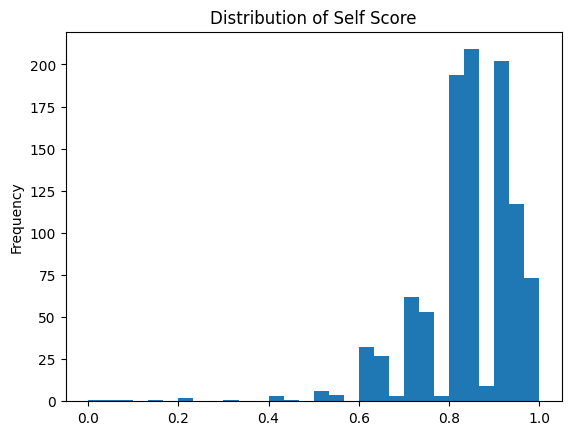

In [20]:
df_ohe['Self Score'].plot(kind='hist', bins=30, title='Distribution of Self Score')

In [21]:
print(df_ohe['Self Score'].describe())
print("Median: ",df_ohe['Self Score'].median())
print("Mode: ",df_ohe['Self Score'].mode())

count    1005.000000
mean        0.835015
std         0.118163
min         0.000000
25%         0.800000
50%         0.850000
75%         0.900000
max         1.000000
Name: Self Score, dtype: float64
Median:  0.85
Mode:  0    0.85
Name: Self Score, dtype: float64


In [22]:
cols_gi = df_ohe.columns[
    df_ohe.columns.str.contains(
        'Activities|Facilities|Number of workers|Country',
        case=False,
        regex=True
    )
].tolist()
len(cols_gi)

33

In [23]:
# Temporarily drop rows with missing values / we can later try imputing them since they are few
df_ohe = df_ohe.dropna(axis=0, how="any")

In [24]:
X = df_ohe[cols_gi]
y = df_ohe['Val_Score']                  # target
groups = df_ohe['ID']                    # supplier ID

gss = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [25]:
X_test.head()

,Activities - Raw material extraction,Activities - Plastic molding,Activities - Component manufacturing,Activities - Sub-assembly,Activities - Printed Circuit Board manufacturing,Activities - Printed Circuit Board assembly / mounting,Activities - Painting / coating,Activities - Die casting / stamping / metal processing,Activities - Clean room,Activities - Final assembly,Activities - Logistics & distribution,Facilities - Hospital / infirmary,Facilities - Dormitory on site or employer provided accommodation close to the site,Facilities - Canteen,Facilities - Kitchen,Facilities - Power generation,Facilities - Chemical warehouse,Facilities - Waste water treatment facility,Number of workers - Total,Number of workers - Male,Number of workers - Female,Number of workers - Young workers,Number of workers - Direct employed,Country_China,Country_Germany,Country_India,Country_Indonesia,Country_Italy,Country_N/a,Country_Taiwan,Country_Thailand,Country_Turkey,Country_Yemen
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,165,125,40,0,0.0,False,False,False,True,False,False,False,False,False,False
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,302,222,80,0,282.0,False,False,False,True,False,False,False,False,False,False
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,312,218,94,0,312.0,False,False,False,True,False,False,False,False,False,False
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,222,107,115,0,222.0,True,False,False,False,False,False,False,False,False,False
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,222,107,115,0,222.0,True,False,False,False,False,False,False,False,False,False


In [26]:
# Simple baseline: Mean prediction
baseline_pred = np.full(len(y_test), y_train.mean())
rmse_baseline = mean_squared_error(y_test, baseline_pred) ** 0.5
mae_baseline = mean_absolute_error(y_test, baseline_pred)

print(f"Baseline (Mean): RMSE={rmse_baseline:.3f}, MAE={mae_baseline:.3f}")

Baseline (Mean): RMSE=0.189, MAE=0.158


In [27]:
# Train the baseline GI model
model_gi = LinearRegression()
model_gi.fit(X_train, y_train)

gi_preds = model_gi.predict(X_test)

In [28]:
rmse_gi = mean_squared_error(y_test, gi_preds) ** 0.5
mae_gi  = mean_absolute_error(y_test, gi_preds)

print('RMSE: ',rmse_gi, ' MAE: ', mae_gi)

RMSE:  0.18240630174735553  MAE:  0.1479776053381031


In [29]:
# Feature importance for baseline GI model
importance = pd.Series(model_gi.coef_, index=cols_gi).sort_values(ascending=False)
importance.head(10)

Country_Yemen                                             0.161592
Activities - Printed Circuit Board manufacturing          0.093633
Activities - Printed Circuit Board assembly / mounting    0.052277
Facilities - Canteen                                      0.051267
Facilities - Kitchen                                      0.050689
Country_Turkey                                            0.047540
Facilities - Chemical warehouse                           0.045221
Activities - Plastic molding                              0.033176
Country_India                                             0.027017
Facilities - Waste water treatment facility               0.024977
dtype: float64

In [30]:
# Identify the columns that start with 'Q' for SAQ features
saq_cols = df_ohe.columns[df_ohe.columns.str.startswith('Q')].tolist()


In [31]:
gi_saq_cols = cols_gi + saq_cols

In [32]:
X = df_ohe[gi_saq_cols]
y = df_ohe['Val_Score']
groups = df_ohe['ID']         # supplier identifier → prevents leakage

In [33]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [34]:
model_gi_saq = LinearRegression()
model_gi_saq.fit(X_train, y_train)

gi_saq_preds = model_gi_saq.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, gi_saq_preds)
rmse_gi_saq = mse ** 0.5
mae_gi_saq = mean_absolute_error(y_test, gi_saq_preds)

rmse_gi_saq, mae_gi_saq

(0.23762240637008353, 0.1843143773230639)

In [36]:
coefs = pd.Series(
    model_gi_saq.coef_,
    index = gi_saq_cols
)

# sort by absolute weight
importance_linear = coefs.abs().sort_values(ascending=False)

importance_linear.head(20)


Country_Yemen                           0.531955
Q1406                                   0.517156
Q1409_3                                 0.349822
Country_Indonesia                       0.305895
Activities - Raw material extraction    0.287401
Country_Turkey                          0.193058
Q1409_4                                 0.192163
Q224                                    0.175812
Q1409_2                                 0.171998
Q594                                    0.162076
Q958_6                                  0.161393
Q959_2                                  0.158026
Q959_7                                  0.154441
Q1001_1                                 0.142018
Q1239                                   0.141545
Q730                                    0.138897
Q808_2                                  0.137668
Q958_7                                  0.136486
Q736                                    0.134005
Q1333                                   0.130706
dtype: float64

In [37]:
lasso = Lasso(alpha=0.001, max_iter=5000)
lasso.fit(X_train, y_train)

gi_saq_preds_lasso = lasso.predict(X_test)

rmse_lasso = (mean_squared_error(y_test, gi_saq_preds_lasso))**0.5
mae_lasso  = mean_absolute_error(y_test, gi_saq_preds_lasso)

rmse_lasso, mae_lasso

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e+00, tolerance: 3.037e-03
  model = cd_fast.enet_coordinate_descent(


(0.15268159732277517, 0.12396748685231739)

In [38]:
coefs = pd.Series(
    lasso.coef_,
    index = gi_saq_cols
)

importance_lasso = coefs.abs().sort_values(ascending=False)
importance_lasso.head(20)


Q1272                                                     0.077597
Q1238                                                     0.068456
Q1296                                                     0.060967
Q1297                                                     0.054942
Q1224                                                     0.054601
Q1625                                                     0.053149
Q1001_8                                                   0.052111
Q636_2                                                    0.049037
Q959_12                                                   0.046730
Q224                                                      0.046714
Q967                                                      0.045110
Q1278                                                     0.044449
Activities - Raw material extraction                      0.043436
Q958_12                                                   0.037447
Q636_6                                                    0.03

In [39]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [40]:
xgb_preds = xgb.predict(X_test)

rmse_xgb = (mean_squared_error(y_test, xgb_preds))**0.5
mae_xgb  = mean_absolute_error(y_test, xgb_preds)

rmse_xgb, mae_xgb

(0.1547112962474805, 0.124036487089461)

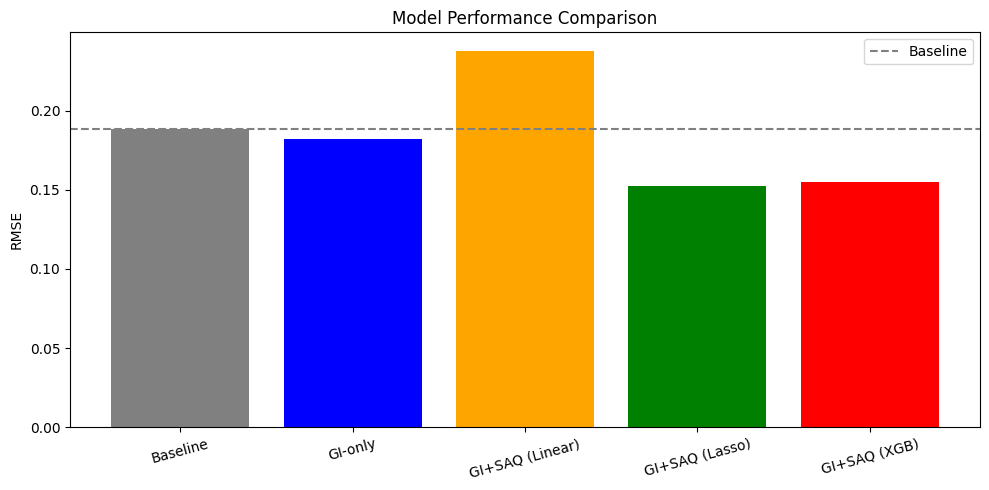

In [41]:
models = ['Baseline', 'GI-only', 'GI+SAQ (Linear)', 'GI+SAQ (Lasso)', 'GI+SAQ (XGB)']
rmses = [rmse_baseline, rmse_gi, rmse_gi_saq, rmse_lasso, rmse_xgb]

plt.figure(figsize=(10, 5))
plt.bar(models, rmses, color=['gray', 'blue', 'orange', 'green', 'red'])
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.xticks(rotation=15)
plt.axhline(y=rmse_baseline, color='gray', linestyle='--', label='Baseline')
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


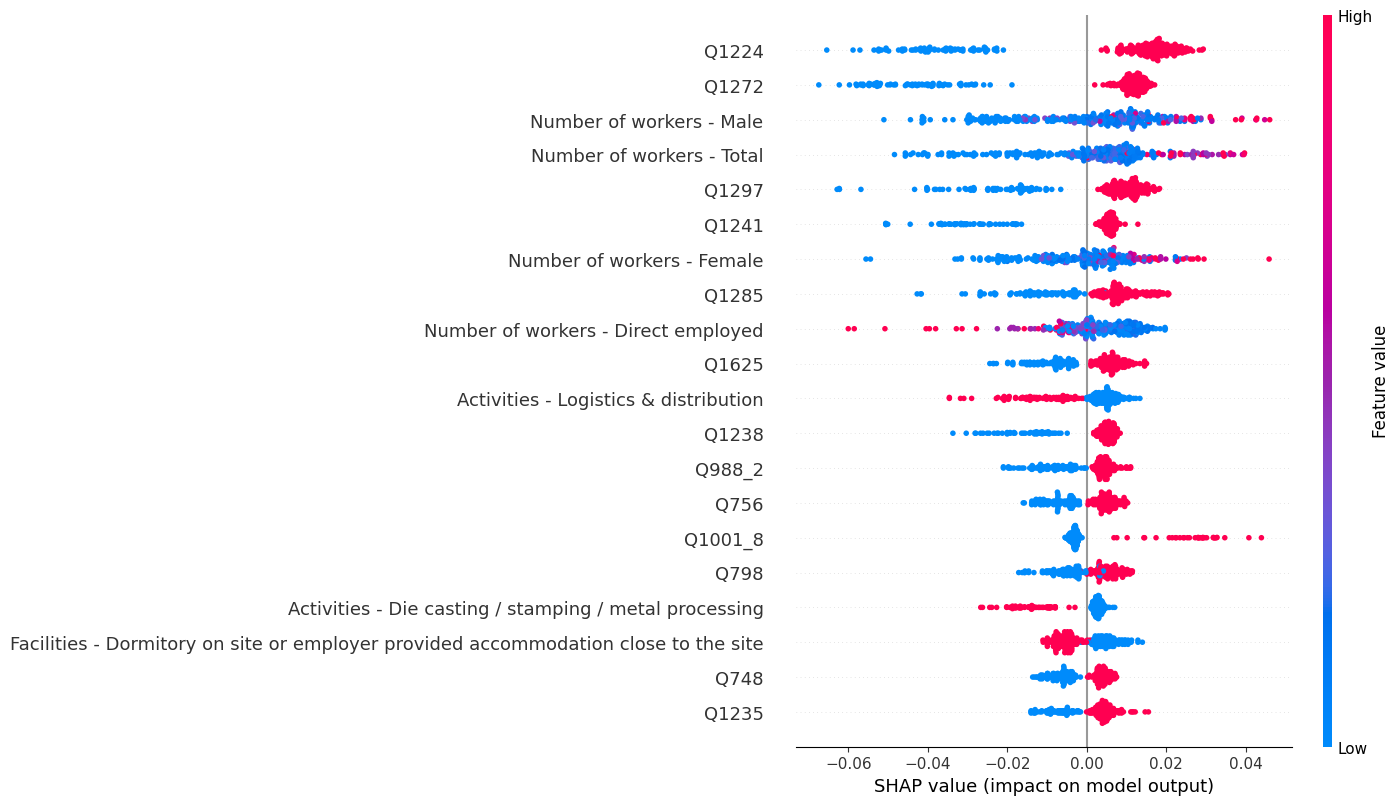

In [42]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, max_display=20)
#TODO: interpret the plot

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

threshold = df_ohe['Val_Score'].quantile(0.75)

y_train_class = (y_train >= threshold).astype(int)  # 1 = BIC, 0 = RFI
y_test_class = (y_test >= threshold).astype(int)

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train_class)

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred_class = log_reg.predict(X_test)

print(f"ROC-AUC: {roc_auc_score(y_test_class, y_pred_proba):.3f}")
print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class):.3f}")
print(classification_report(y_test_class, y_pred_class))

ROC-AUC: 0.847
Accuracy: 0.812
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       231
           1       0.55      0.51      0.53        61

    accuracy                           0.81       292
   macro avg       0.71      0.70      0.71       292
weighted avg       0.81      0.81      0.81       292



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


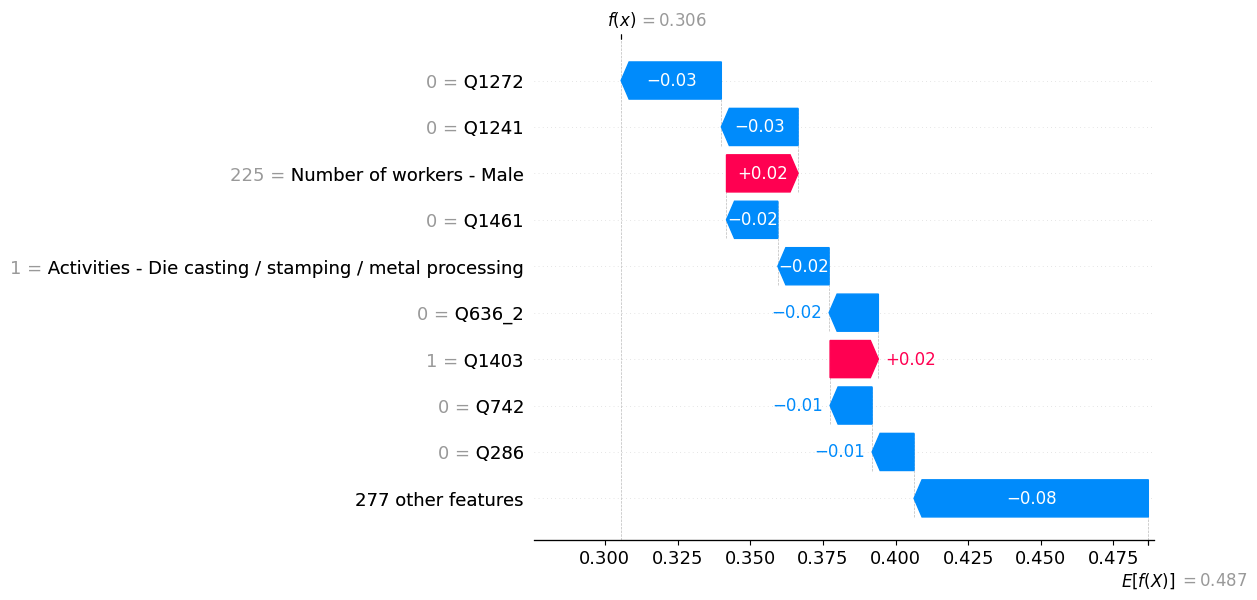

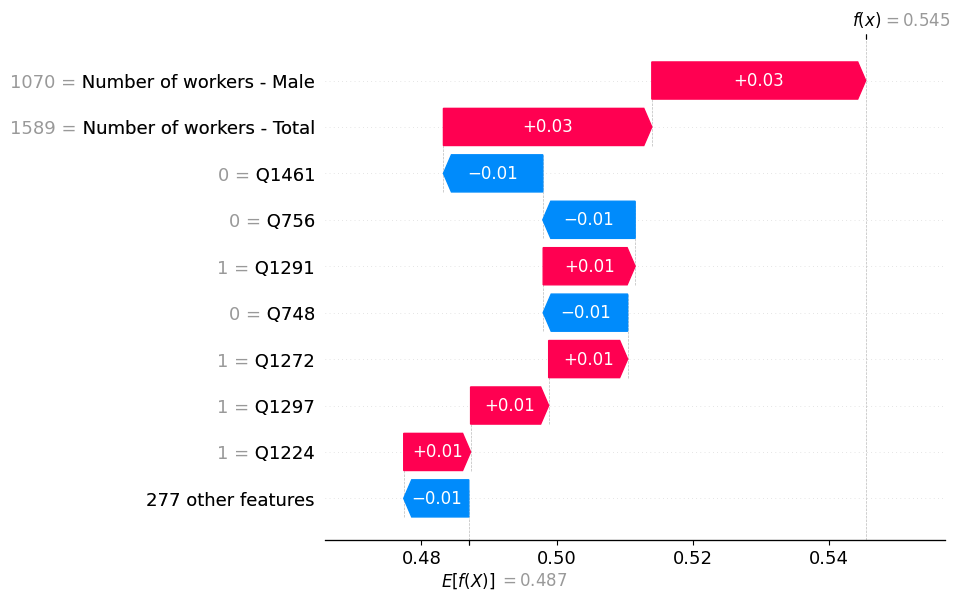

In [44]:
# Pick one low-score and one high-score supplier
low_idx = y_test.idxmin()
high_idx = y_test.idxmax()

# SHAP Waterfall plots
shap.waterfall_plot(shap.Explanation(
    values=shap_values[X_test.index.get_loc(low_idx)],
    base_values=explainer.expected_value,
    data=X_test.loc[low_idx],
    feature_names=X_test.columns.tolist()
))

shap.waterfall_plot(shap.Explanation(
    values=shap_values[X_test.index.get_loc(high_idx)],
    base_values=explainer.expected_value,
    data=X_test.loc[high_idx],
    feature_names=X_test.columns.tolist()
))

In [45]:
# Create risk tiers based on predicted scores
def assign_risk_tier(score):
    if score >= 80: return "Low Risk"
    elif score >= 65: return "Moderate Risk"
    elif score >= 50: return "Medium Risk"
    elif score >= 35: return "High Risk"
    else: return "Critical Risk"

predictions_df = pd.DataFrame({
    'Actual_Score': y_test,
    'Predicted_Score': xgb_preds,
    'Risk_Tier': [assign_risk_tier(p) for p in xgb_preds]
})

print(predictions_df['Risk_Tier'].value_counts())

Risk_Tier
Critical Risk    292
Name: count, dtype: int64


In [46]:
from sklearn.metrics import confusion_matrix

# Get country for each test sample
country_cols = [c for c in df_ohe.columns if c.startswith('Country_')]
test_countries = df_ohe.loc[X_test.index, country_cols].idxmax(axis=1).str.replace('Country_', '')

# Binary classification (BIC vs RFI)
threshold = df_ohe['Val_Score'].quantile(0.75)
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (xgb_preds >= threshold).astype(int)

# Calculate FNR and FPR by country
print("FAIRNESS CHECK BY REGION:")
for country in test_countries.unique():
    mask = test_countries == country
    if mask.sum() < 5:
        continue
    
    y_true = y_test_binary[mask]
    y_pred = y_pred_binary[mask]
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    print(f"{country} (n={mask.sum()}): FNR={fnr:.3f}, FPR={fpr:.3f}")

FAIRNESS CHECK BY REGION:
Indonesia (n=8): FNR=1.000, FPR=0.000
China (n=265): FNR=0.604, FPR=0.090
India (n=18): FNR=0.833, FPR=0.167
